In [141]:
import torch
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.dirname('../.'))
from ml.SampleClass import Sample
from scripts.utils import get_path
from scripts.load_and_save import save_vol_as_nii

In [130]:
model_name = 'Unet3d'
sample_name = 'IXI111'

In [132]:
path_to_GT = f'/home/msst/Documents/medtech/data/Inference_IXI/{sample_name}'
path_to_SEG = get_path(f'/home/msst/IXI_MRA_work/{sample_name}', model_name)
#GT
sample = Sample(path_to_GT)
subject = sample.get_subject()
vessels_GT = subject.vessels.data[0].numpy()
brain = subject.brain.data[0].numpy()
vessels_GT_masked = vessels_GT*brain

#SEG
img = tio.LabelMap(path_to_SEG)
vessels_SEG = img.data[0].numpy()
vessels_SEG_masked = vessels_SEG*brain

In [133]:
def transform_to_show(img):
    return np.flip(img.T, axis=0)

def get_errors_image(MIP_GT, MIP_SEG):
    SIZE = MIP_GT.shape
    Errors = np.zeros((SIZE[0], SIZE[1], 3))
    Errors[:, :, 1][(MIP_GT>0)*(MIP_GT==MIP_SEG)] = 1
    Errors[:, :, 0][MIP_GT>MIP_SEG] = 1
    Errors[:, :, 2][MIP_GT<MIP_SEG] = 1
    return(Errors)

In [134]:
MIP_GT = transform_to_show(np.max(vessels_GT, axis=2))
MIP_GT_masked = transform_to_show(np.max(vessels_GT_masked, axis=2))

MIP_SEG = transform_to_show(np.max(vessels_SEG, axis=2))
MIP_SEG_masked = transform_to_show(np.max(vessels_SEG_masked, axis=2))

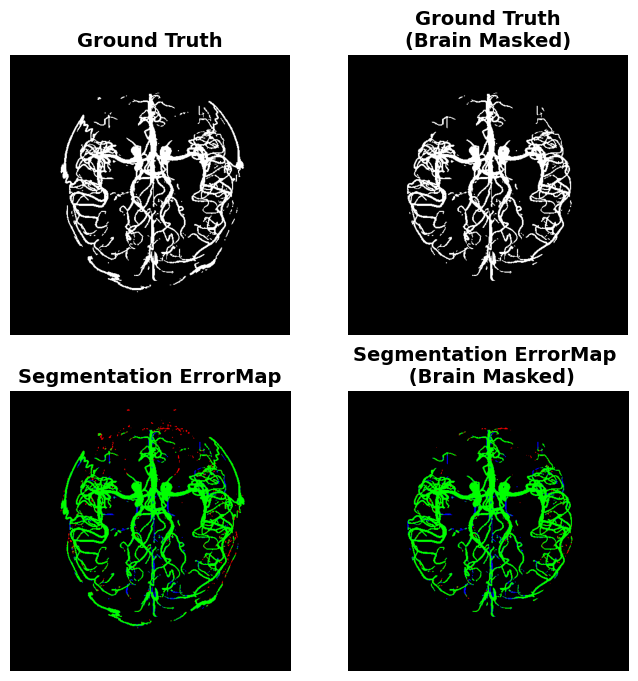

In [135]:
fig, ax = plt.subplots(2, 2, figsize = (8,8))

ax[0][0].set_axis_off()
ax[0][1].set_axis_off()
ax[1][0].set_axis_off()
ax[1][1].set_axis_off()

ax[0][0].imshow(MIP_GT, cmap='gray')
ax[0][0].set_title("Ground Truth", fontsize = 14, fontweight ='bold') 
ax[0][1].imshow(MIP_GT_masked, cmap='gray')
ax[0][1].set_title("Ground Truth\n(Brain Masked)", fontsize = 14, fontweight ='bold') 

ax[1][0].imshow(get_errors_image(MIP_SEG, MIP_GT))
ax[1][0].set_title("Segmentation ErrorMap", fontsize = 14, fontweight ='bold') 
ax[1][1].imshow(get_errors_image(MIP_SEG_masked, MIP_GT_masked))
ax[1][1].set_title("Segmentation ErrorMap \n (Brain Masked)", fontsize = 14, fontweight ='bold') 

plt.show() 

In [106]:
fig.savefig(f'/home/msst/RESULTS_HessNet.jpg', dpi=250)

In [147]:
def get_error_vol(vol_GT, vol_SEG):
    assert vol_GT.shape == vol_SEG.shape
    error_vol = np.zeros_like(vol_GT, dtype=np.uint8)
    error_vol[(vol_GT>0)*(vol_GT==vol_SEG)] =1
    error_vol[(vol_GT>vol_SEG)]=2
    error_vol[(vol_GT<vol_SEG)]=3
    return(error_vol)

In [150]:
error_vol = get_error_vol(vessels_GT_masked, vessels_SEG_masked)

In [151]:
path_to_save_sample = f'/home/msst/IXI_MRA_work/{sample_name}/{model_name}_ErrorMap.nii.gz'
save_vol_as_nii(error_vol, subject.head.affine, path_to_save_sample)